In [33]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
%matplotlib inline

In [34]:
connection = {
'host': 'https://',
'password': '####',
'user': '####',
'database': '####'
}

In [35]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [36]:
# Common CTR in control groups 0, 1
global_ctr_0 = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum() 
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum() 

In [37]:
global_ctr_0

0.20823612262916305

In [38]:
global_ctr_1

0.20802680490126244

In [39]:
group_0 = df[df.exp_group == 0].copy()
group_1 = df[df.exp_group == 1].copy()
group_2 = df[df.exp_group == 2].copy()
group_3 = df[df.exp_group == 3].copy()

In [55]:
# Metric of linearized likes in control groups 0, 1, 2, 3
group_0['linearized_likes'] = group_0['likes'] - (global_ctr_0 * group_0['views'])
group_1['linearized_likes'] = group_1['likes'] - (global_ctr_1 * group_1['views'])
group_2['linearized_likes'] = group_2['likes'] - (global_ctr_1 * group_2['views'])
group_3['linearized_likes'] = group_3['likes'] - (global_ctr_0 * group_3['views'])

In [41]:
linearized_df = pd.concat([group_0, group_1, group_2,group_3], ignore_index = True)
linearized_df

,exp_group,user_id,likes,views,ctr,linearized_likes
0,0,30319,21,110,0.190909,-1.905973
1,0,7626,14,39,0.358974,5.878791
2,0,111277,2,13,0.153846,-0.707070
3,0,27199,4,34,0.117647,-3.080028
4,0,3450,10,42,0.238095,1.254083
...,...,...,...,...,...,...
40074,3,108659,0,9,0.000000,-1.874125
40075,3,123869,24,78,0.307692,7.757582
40076,3,11263,25,62,0.403226,12.089360
40077,3,122758,30,198,0.151515,-11.230752


Let's see the groups 0 and 3

In [42]:
linearized_df_0_3 = pd.concat([group_0,group_3], ignore_index = True)

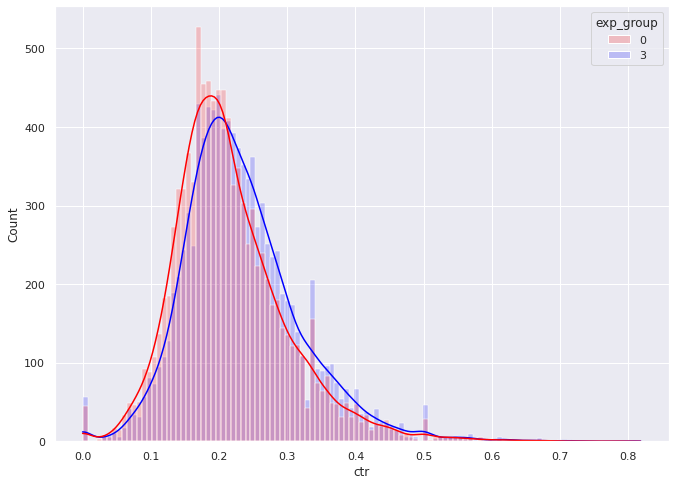

In [43]:
sns.set(rc={'figure.figsize':(11,8)})

groups = sns.histplot(data = linearized_df_0_3,
                      x='ctr',
                      hue='exp_group',
                      palette=['red', 'blue'],
                      alpha=0.2,
                      kde=True)

In [44]:
# t-test for CTR in 0,3 groups

_, pval_t_ctr = stats.ttest_ind(linearized_df[linearized_df.exp_group == 0].ctr,
               linearized_df[linearized_df.exp_group == 3].ctr,
               equal_var=False)
print('Результат при проведении t-теста p-value для ctr = ', pval_t_ctr)

Результат при проведении t-теста p-value для ctr =  1.055849414662529e-43


In [45]:
# t-test for likes in groups 0 and 3

_, pval_t_like = stats.ttest_ind(linearized_df[linearized_df.exp_group == 0].linearized_likes,
               linearized_df[linearized_df.exp_group == 3].linearized_likes,
               equal_var=False)
print('Результат при проведении t-теста p-value для likes = ', pval_t_like)

Результат при проведении t-теста p-value для likes =  5.4914249479690016e-52


In [46]:
# Mann-Whitney test for CTR in groups 0 and 3

_, pval_mw_ctr = stats.mannwhitneyu(linearized_df[linearized_df.exp_group == 0].ctr,
               linearized_df[linearized_df.exp_group == 3].ctr,
               alternative='two-sided')
print('Результат при проведении теста Манна-Уитни p-value для ctr = ', pval_mw_ctr)

Результат при проведении теста Манна-Уитни p-value для ctr =  1.1952055473582936e-57


In [47]:
# Mann-Whitney test for likes in groups 0 and 3

_, pval_mw_like = stats.mannwhitneyu(linearized_df[linearized_df.exp_group == 0].linearized_likes,
               linearized_df[linearized_df.exp_group == 3].linearized_likes,
               alternative='two-sided')
print('Результат при проведении теста Манна-Уитни p-value для ctr = ', pval_mw_like)

Результат при проведении теста Манна-Уитни p-value для ctr =  1.1517315029786597e-63


The tests in groups 0 and 3 show that the linearized likes method did not affect the interpretation of the results, since the p-value turned out to be very close to zero both when comparing likes and when comparing ctr. It can be seen from the graph that the distributions of ctr in groups 0 and 3 are close to normal.

Let's see groups 1 and 2

In [49]:
linearized_df_1_2 = pd.concat([group_1,group_2], ignore_index = True)

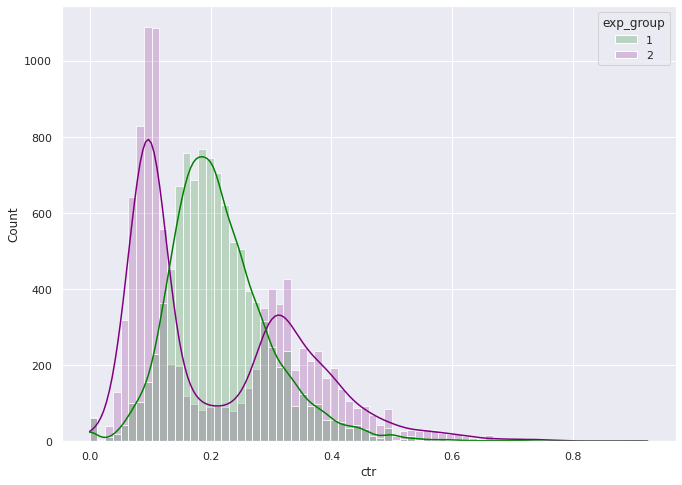

In [50]:
sns.set(rc={'figure.figsize':(11,8)})

groups = sns.histplot(data = linearized_df_1_2,
                      x='ctr',
                      hue='exp_group',
                      palette=['green', 'purple'],
                      alpha=0.2,
                      kde=True)

In [51]:
# t-test for ctr in groups 1 and 2

_, pval_t_ctr = stats.ttest_ind(linearized_df[linearized_df.exp_group == 1].ctr,
               linearized_df[linearized_df.exp_group == 2].ctr,
               equal_var=False)
print('Результат при проведении t-теста p-value для ctr = ', pval_t_ctr)

Результат при проведении t-теста p-value для ctr =  0.4780623130874935


In [52]:
# t-test for likes in groups 1 and 2

_, pval_t_like = stats.ttest_ind(linearized_df[linearized_df.exp_group == 1].linearized_likes,
               linearized_df[linearized_df.exp_group == 2].linearized_likes,
               equal_var=False)
print('Результат при проведении p-value для likes = ', pval_t_like)

Результат при проведении p-value для likes =  9.439432187037712e-10


In [53]:
# Mann-Whitney test for ctr in groups 1 and 2

_, pval_mw_ctr = stats.mannwhitneyu(linearized_df[linearized_df.exp_group == 1].ctr,
               linearized_df[linearized_df.exp_group == 2].ctr,
               alternative='two-sided')
print('Результат при проведении теста Манна-Уитни p-value для ctr = ', pval_mw_ctr)

Результат при проведении теста Манна-Уитни p-value для ctr =  6.0376484617779035e-56


In [54]:
# Mann-Whitney test for likes in groups 1 and 2

_, pval_mw_likes = stats.mannwhitneyu(linearized_df[linearized_df.exp_group == 1].linearized_likes,
               linearized_df[linearized_df.exp_group == 2].linearized_likes,
               alternative='two-sided')
print('Результат при проведении теста Манна-Уитни p-value для ctr = ', pval_mw_likes)

Результат при проведении теста Манна-Уитни p-value для ctr =  9.404319579641738e-27


The tests in groups 1 and 2 show that the t-test gives a very large p-value when comparing ctr, unlike likes, which allows us to reject the H0 about the equality of the distributions of the test and control groups. The Mann-Whitney test works correctly both in the case of ctr and likes.



Total:
When conducting a t-test with counting likes instead of ctr when comparing groups 0 and 3, the p-value did not change, which does not allow us to reject the H0, unlike groups 1 and 2, where counting likes instead of ctr reduced the p-value , which allows us to reject the hypothesis about the equality of the distributions of the test and control groups.

When conducting the Mann-Whitney test, the p-value did not change significantly when comparing groups 0 and 3, as well as groups 1 and 2.

